### Initialize Spark Session and Read CSV File

1. **Read data from the file `"dataFIFA.csv"`**.

In [1]:
from pyspark.sql import SparkSession

# Read the CSV file
df = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .option("encoding", "UTF-8") \
    .csv("dataFIFA.csv")

# Show the first 5 rows
df.show(5)

25/01/16 23:37:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+-------+-----+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Log

25/01/16 23:37:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Preferred Foot, International Reputation, Weak Foot, Skill Moves, Work Rate, Body Type, Real Face, Position, Jersey Number, Joined, Loaned From, Contract Valid Until, Height, Weight, LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB, Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys, Dribbling, Curve, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Aggression, Interceptions, Positioning, Vision, Penalties, Composure, Marking, StandingTackle, SlidingTackle, GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes, Release Clause
 Schema: _c0, ID, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value,

### **1. Fill the Table for Feature Types and Transformations**

5 mix of numerical and categorical features.

| **Column Name**   | **Feature Type** | **Way to Manage Feature** | **Example (Before -> After)** |
|-------------------|------------------|--------------------------|------------------------------|
| `Wage`            | Numerical         | Convert from €K to number | €565K -> 565000            |
| `Age`             | Numerical         | No encoding needed        | 31 -> 31                      |
| `Preferred Foot`  | Categorical        | One-Hot Encoding          | Left -> [1, 0], Right -> [0, 1] |
| `Position`        | Categorical        | Label Encoding            | ST -> 1, GK -> 2              |
| `Overall`         | Numerical          | No encoding needed        | 94 -> 94                      |


In [2]:
# Print schema to see data types of columns
df.printSchema()

# Show the number of rows and columns
print(f"Number of rows: {df.count()}, Number of columns: {len(df.columns)}")

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nu

### Drop Index Column

In [3]:
# Drop index column
if "_c0" in df.columns:
    df = df.drop("_c0")

### Data Cleaning (Handle Special Columns)
Clean "Value", "Wage" and "Release Clause" Columns (Remove € and Convert M/K to Numeric) and normalize them

In [4]:
from pyspark.sql.functions import regexp_replace, col, when, min as spark_min, max as spark_max, format_number

# Clean "Value" column
df = df.withColumn("Value_num", regexp_replace("Value", "[€MK]", "").cast("double") *
                                when(col("Value").like("%M"), 1e6).otherwise(1e3))

# Clean "Wage" column
df = df.withColumn("Wage_num", regexp_replace("Wage", "[€MK]", "").cast("double") *
                               when(col("Wage").like("%K"), 1e3).otherwise(1))

# Clean "Release Clause" column
df = df.withColumn("Release_Clause_num", regexp_replace("Release Clause", "[€MK]", "").cast("double") *
                               when(col("Value").like("%M"), 1e6).otherwise(1e3))

# Calculate min wage and max value using Spark functions
weight_stats = df.select(
    spark_min(col("Wage_num")).alias("min_euro"),
    spark_max(col("Release_Clause_num")).alias("max_euro")
).collect()[0]

euro_min = weight_stats["min_euro"]
euro_max = weight_stats["max_euro"]

print(f'The minimal wage is: {euro_min} Euro')
print(f'The maximal player value is: {euro_max} Euro')

# Normalize the Value_num column
df = df.withColumn(
    "Value_norm",(col("Value_num") - euro_min) / (euro_max - euro_min))

# Normalize the Wage_norm column
df = df.withColumn(
    "Wage_norm",(col("Wage_num") - euro_min) / (euro_max - euro_min))

# Normalize the Release_Clause_num column
df = df.withColumn(
    "Release_Clause_norm",(col("Release_Clause_num") - euro_min) / (euro_max - euro_min))


df.select("Name", "Value", "Value_num", "Value_norm", "Wage", "Wage_num", "Wage_norm"
          ,"Release Clause","Release_Clause_num","Release_Clause_norm").show(5)

The minimal wage is: 0.0 Euro
The maximal player value is: 228100000.0 Euro
+-----------------+-------+---------+------------------+-----+--------+--------------------+--------------+------------------+-------------------+
|             Name|  Value|Value_num|        Value_norm| Wage|Wage_num|           Wage_norm|Release Clause|Release_Clause_num|Release_Clause_norm|
+-----------------+-------+---------+------------------+-----+--------+--------------------+--------------+------------------+-------------------+
|         L. Messi|€110.5M|  1.105E8|0.4844366505918457|€565K|565000.0|0.002476983779044...|       €226.5M|           2.265E8| 0.9929855326611136|
|Cristiano Ronaldo|   €77M|    7.7E7|0.3375712406839106|€405K|405000.0|0.001775537045155...|       €127.1M|           1.271E8| 0.5572117492327926|
|        Neymar Jr|€118.5M|  1.185E8|0.5195089872862779|€290K|290000.0|0.001271372205173...|       €228.1M|           2.281E8|                1.0|
|           De Gea|   €72M|    7.2E7|0.315

In [5]:
from pyspark.sql.functions import regexp_extract

# Extract feet and inches using regex
# Feet: The part before the single quote (e.g., "5" in "5'7")
# Inches: The part after the single quote (e.g., "7" in "5'7")
df = df.withColumn("feet", regexp_extract(col("Height"), r"(\d+)'", 1).cast("int")) \
       .withColumn("inches", regexp_extract(col("Height"), r"'(\d+)", 1).cast("int"))

# Calculate height in meters
df = df.withColumn("height_meters", (col("feet") * 0.3048 + col("inches") * 0.0254))

# Show the results
df.select("Name", "Height", "feet", "inches", "height_meters").show(5, truncate= True)


+-----------------+------+----+------+------------------+
|             Name|Height|feet|inches|     height_meters|
+-----------------+------+----+------+------------------+
|         L. Messi|   5'7|   5|     7|            1.7018|
|Cristiano Ronaldo|   6'2|   6|     2|1.8796000000000002|
|        Neymar Jr|   5'9|   5|     9|            1.7526|
|           De Gea|   6'4|   6|     4|1.9304000000000001|
|     K. De Bruyne|  5'11|   5|    11|            1.8034|
+-----------------+------+----+------+------------------+
only showing top 5 rows



In [6]:
# Remove "lbs" and convert to integer
df = df.withColumn("Weight_int", regexp_replace(col("Weight"), "lbs", "").cast("int"))

# Calculate min and max weight using Spark functions
weight_stats = df.select(
    spark_min(col("Weight_int")).alias("min_weight"),
    spark_max(col("Weight_int")).alias("max_weight")
).collect()[0]

weight_min = weight_stats["min_weight"]
weight_max = weight_stats["max_weight"]

# Normalize the weight column
df = df.withColumn(
    "Normalized_Weight",
    ((col("Weight_int") - weight_min) / (weight_max - weight_min))
)
print(f'The minimal weight is: {weight_min}lbs')
print(f'The maximal weight is: {weight_max}lbs')

# Show the results
df.select("Name", "Weight", "Weight_int", "Normalized_Weight").show(5)

The minimal weight is: 110lbs
The maximal weight is: 243lbs
+-----------------+------+----------+-------------------+
|             Name|Weight|Weight_int|  Normalized_Weight|
+-----------------+------+----------+-------------------+
|         L. Messi|159lbs|       159| 0.3684210526315789|
|Cristiano Ronaldo|183lbs|       183| 0.5488721804511278|
|        Neymar Jr|150lbs|       150| 0.3007518796992481|
|           De Gea|168lbs|       168|0.43609022556390975|
|     K. De Bruyne|154lbs|       154| 0.3308270676691729|
+-----------------+------+----------+-------------------+
only showing top 5 rows



In [7]:
# Creating a list of column that contain a 2 digit number (percentage) with a pluse sign and a digit tat represent the error.
# this is to modify their content so only the 2 digit will remain.

column_list = ["LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM",
            "RAM","LM","LCM","CM","RCM","RM","LWB","LDM","CDM","RDM","RWB","LB","LCB","CB","RCB","RB"]

# Show the columns befor the change
df.select(column_list).show(2)

for column in column_list:
    df = df.withColumn(column, regexp_replace(col(column), r"\+\d", "")) # removing the + and the digit
    
# Show the results
df.select(column_list).show(2)    


+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  LS|  ST|  RS|  LW|  LF|  CF|  RF|  RW| LAM| CAM| RAM|  LM| LCM|  CM| RCM|  RM| LWB| LDM| CDM| RDM| RWB|  LB| LCB|  CB| RCB|  RB|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|88+2|88+2|88+2|92+2|93+2|93+2|93+2|92+2|93+2|93+2|93+2|91+2|84+2|84+2|84+2|91+2|64+2|61+2|61+2|61+2|64+2|59+2|47+2|47+2|47+2|59+2|
|91+3|91+3|91+3|89+3|90+3|90+3|90+3|89+3|88+3|88+3|88+3|88+3|81+3|81+3|81+3|88+3|65+3|61+3|61+3|61+3|65+3|61+3|53+3|53+3|53+3|61+3|
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
only showing top 2 rows

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| LS| ST| RS| LW| LF| CF| RF| RW|LAM|CAM|RAM| LM|LCM| CM|RCM| RM|LWB|LDM|CDM|

In [8]:
# Normalizing all columns containg percentage
column_list_percentage = ["LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM",
            "RAM","LM","LCM","CM","RCM","RM","LWB","LDM","CDM","RDM","RWB","LB"
            ,"LCB","CB","RCB","RB","Crossing","Finishing","HeadingAccuracy","ShortPassing"
            ,"Volleys","Dribbling","Curve","FKAccuracy","LongPassing","BallControl"
            ,"Acceleration","SprintSpeed","Agility","Reactions","Balance","ShotPower"
            ,"Jumping","Stamina","Strength","LongShots","Aggression","Interceptions"
            ,"Positioning","Vision","Penalties","Composure","Marking","StandingTackle"
            ,"SlidingTackle","GKDiving","GKHandling","GKKicking","GKPositioning","GKReflexes",
            "Overall", "Potential"
]

for column in column_list_percentage:
    df = df.withColumn(column,col(column).cast("float") / 100) # normrmalizing to between 0 to 1
    
# Show the results
df.select(column_list_percentage).show(2)      

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-------+---------+
|  LS|  ST|  RS|  LW|  LF|  CF|  RF|  RW| LAM| CAM| RAM|  LM| LCM|  CM| RCM|  RM| LWB| LDM| CDM| RDM| RWB|  LB| LCB|  CB| RCB|  RB|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|GKDiving|GKHandling|GKKicking|GKPositioning|GKReflexes|O

### Handle Null Values
Count Null Values for Each Column

In [9]:
df.select("Joined").show(2)     

+------------+
|      Joined|
+------------+
| Jul 1, 2004|
|Jul 10, 2018|
+------------+
only showing top 2 rows



In [10]:
from pyspark.sql.functions import col, year, when, to_date

df = df.withColumn(
    "Joined_year",
    when(col("Joined").rlike("^[0-9]{4}$"), col("Joined").cast("int"))  # If it's just a year
    .otherwise(year(to_date(col("Joined"), "MMM d, yyyy")))          # Parse and extract year
)
df = df.withColumn(
    "Contract_Valid_Until_year",
    when(col("Contract Valid Until").rlike("^[0-9]{4}$"), col("Contract Valid Until").cast("int"))  # If it's just a year
    .otherwise(year(to_date(col("Contract Valid Until"), "MMM d, yyyy")))          # Parse and extract year
)

# Show the results
df.select("Joined", "Joined_year", "Contract Valid Until", "Contract_Valid_Until_year").show(30)      

+------------+-----------+--------------------+-------------------------+
|      Joined|Joined_year|Contract Valid Until|Contract_Valid_Until_year|
+------------+-----------+--------------------+-------------------------+
| Jul 1, 2004|       2004|                2021|                     2021|
|Jul 10, 2018|       2018|                2022|                     2022|
| Aug 3, 2017|       2017|                2022|                     2022|
| Jul 1, 2011|       2011|                2020|                     2020|
|Aug 30, 2015|       2015|                2023|                     2023|
| Jul 1, 2012|       2012|                2020|                     2020|
| Aug 1, 2012|       2012|                2020|                     2020|
|Jul 11, 2014|       2014|                2021|                     2021|
| Aug 1, 2005|       2005|                2020|                     2020|
|Jul 16, 2014|       2014|                2021|                     2021|
| Jul 1, 2014|       2014|            

In [11]:
from pyspark.sql.functions import col, sum

# Count nulls for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Convert to Pandas and transpose for easier readability
null_counts_pd = null_counts.toPandas().transpose()

# Reset index for easier column filtering
null_counts_pd.reset_index(inplace=True)

# Rename columns for clarity
null_counts_pd.columns = ['Column', 'Null_Count']

threshold = 100

# Filter columns with null counts above the threshold
filtered_null_counts = null_counts_pd[null_counts_pd['Null_Count'] >= threshold]

# Print the filtered columns
filtered_null_counts.head(100)

,Column,Null_Count
8,Club,241
22,Joined,1553
23,Loaned From,16943
24,Contract Valid Until,289
27,LS,2085
28,ST,2085
29,RS,2085
30,LW,2085
31,LF,2085
32,CF,2085


In [12]:
# Filter columns with null counts between 0 and the threshold
filtered_null_counts_low = null_counts_pd[
    (null_counts_pd['Null_Count'] > 0) & (null_counts_pd['Null_Count'] < threshold)
]

# Print the filtered columns
filtered_null_counts_low.head(100)


,Column,Null_Count
13,Preferred Foot,48
14,International Reputation,48
15,Weak Foot,48
16,Skill Moves,48
17,Work Rate,48
18,Body Type,48
19,Real Face,48
20,Position,60
21,Jersey Number,60
25,Height,48


In [13]:
df_clean = df

# Show the number of rows and columns
print(f"Number of rows: {df_clean.count()}, Number of columns: {len(df_clean.columns)} befor cleaning nulls")

# Drop columns with too many nulls and unwanted columns
df_clean = df_clean.drop("ID","Photo","Flag","Club Logo","Real Face","Jersey Number","Loaned From"
                         ,"Joined", "Release Clause","Release_Clause_num","Joined_year","Contract Valid Until", 
                         "Contract_Valid_Until_year", 'Value', 'Wage','Height', 'Weight','feet','inches',
                         'height_meters','Weight_int','Wage_num','Value_num')


column_list_for_zero = ["LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM",
            "RAM","LM","LCM","CM","RCM","RM","LWB","LDM","CDM","RDM","RWB","LB"
            ,"LCB","CB","RCB","RB","Release_Clause_norm"
]

for column in column_list_for_zero:
    df_clean = df_clean.fillna({column: 0,})

# Fill missing dates and text columns
df_clean = df_clean.fillna({"Position": "Unknown", "Club": "Unknown"})

# Drop rows with more than 10 null columns
df_clean = df_clean.na.drop(thresh=len(df_clean.columns) - 10)
 
# Show the number of rows and columns
print(f"Number of rows: {df_clean.count()}, Number of columns: {len(df_clean.columns)} after cleaning nulls")

 # Count nulls for each column
null_counts = df_clean.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_clean.columns])
# Convert to Pandas and transpose for easier readability
null_counts_pd = null_counts.toPandas().transpose()

# Reset index for easier column filtering
null_counts_pd.reset_index(inplace=True)

# Rename columns for clarity
null_counts_pd.columns = ['Column', 'Null_Count']

# Filter rows where 'Null_Count' is not NaN
non_nan_null_counts_df = null_counts_pd[null_counts_pd['Null_Count'] != 0]

non_nan_null_counts_df.head(100)

Number of rows: 18207, Number of columns: 101 befor cleaning nulls


Number of rows: 18159, Number of columns: 78 after cleaning nulls


,Column,Null_Count


###### No null values remain

In [14]:
# Print schema to see data types of columns
df_clean.printSchema()

# Show the number of rows and columns
print(f"Number of rows: {df_clean.count()}, Number of columns: {len(df_clean.columns)}")

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: double (nullable = true)
 |-- Potential: double (nullable = true)
 |-- Club: string (nullable = false)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Position: string (nullable = false)
 |-- LS: double (nullable = false)
 |-- ST: double (nullable = false)
 |-- RS: double (nullable = false)
 |-- LW: double (nullable = false)
 |-- LF: double (nullable = false)
 |-- CF: double (nullable = false)
 |-- RF: double (nullable = false)
 |-- RW: double (nullable = false)
 |-- LAM: double (nullable = false)
 |-- CAM: double (nullable = false)
 |-- RAM: double (nullable = false)
 |-- LM: double (nullab

### Check for Non-Numerical Features

In [15]:
# List non-numerical columns
non_numerical_columns = [f.name for f in df_clean.schema.fields if f.dataType.simpleString() == "string"]
print(f"Non-numerical columns: {non_numerical_columns}")

Non-numerical columns: ['Name', 'Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position']


In [16]:
# Removing the "Name" column so it won't be encoded
non_numerical_columns = ['Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position']
print(f"Non-numerical columns for encoding: {non_numerical_columns}")

Non-numerical columns for encoding: ['Nationality', 'Club', 'Preferred Foot', 'Work Rate', 'Body Type', 'Position']


### Encode All Non-Numerical Columns
We will:

    1. Use StringIndexer to convert categories into numerical indices.
    2.Use OneHotEncoder to create binary vectors (optional, based on your need).

In [17]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Prepare transformations for all non-numerical columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}Index") for col in non_numerical_columns]
encoders = [OneHotEncoder(inputCol=f"{col}Index", outputCol=f"{col}Vec") for col in non_numerical_columns]

# Combine indexers and encoders in a pipeline
stages = indexers + encoders
pipeline = Pipeline(stages=stages)

# Apply pipeline to encode all non-numerical features
df_encoded = pipeline.fit(df_clean).transform(df_clean)

# Show encoded features
df_encoded.show(5)

+-----------------+---+-----------+-------+---------+-------------------+-------+--------------+------------------------+---------+-----------+--------------+----------+--------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+------------------+--------------------+-------------------+-------------------+----------------+---------+-------------------+--------------+--------------+-------------+----------------+-----------------+-----------------+-------------+-------------+---------------+
|             Name|Age|Nationality|Overall|Potential|           

### Combine All Features into a Single Vector

In [18]:
from pyspark.ml.feature import VectorAssembler

# List all numerical features
numerical_columns = [f.name for f in df_clean.schema.fields if f.dataType.simpleString() in ["int", "double"]]

# Include encoded categorical features (Vec columns)
encoded_features = [f"{col}Vec" for col in non_numerical_columns]

# Assemble all features
assembler = VectorAssembler(inputCols=numerical_columns + encoded_features, outputCol="features")
df_features = assembler.transform(df_encoded)

## Apply Feature Selection
### Feature Importance (Using Decision Tree)

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.sql.functions import col, when
from tqdm import tqdm

# Remove 'Value_norm' from numerical columns
numerical_columns_filtered = [col for col in numerical_columns if col != "Value_norm"]

# Assemble features
assembler = VectorAssembler(inputCols=numerical_columns_filtered + encoded_features, outputCol="features")

# Prepare the dataset with features and label
df_features_tree = assembler.transform(df_encoded).select("features", "Value_norm")

# Stratified sampling: create a stratification column
num_buckets = 5
df_stratified = df_features_tree.withColumn(
    "strata",
    when(col("Value_norm") <= 0.2, 1)
    .when(col("Value_norm") <= 0.4, 2)
    .when(col("Value_norm") <= 0.6, 3)
    .when(col("Value_norm") <= 0.8, 4)
    .otherwise(5)
)

# Decision tree regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Value_norm")

# Define parameter grid for Decision Tree
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="Value_norm", predictionCol="prediction", metricName="rmse")

# Manual Cross-validation with progress bar
num_folds = 5
param_combinations = paramGrid
total_iterations = len(param_combinations) * num_folds

# Split the data into folds
folds = df_stratified.randomSplit([1 / num_folds] * num_folds, seed=42)

# Initialize progress bar
with tqdm(total=total_iterations, desc="Cross-validation Progress") as pbar:
    best_model = None
    best_rmse = float("inf")
    
    for params in param_combinations:
        for i in range(num_folds):
            # Prepare training and validation sets
            validation_fold = folds[i]
            training_folds = folds[:i] + folds[i + 1:]
            training_data = training_folds[0]
            for fold in training_folds[1:]:
                training_data = training_data.union(fold)
            
            # Train the model
            model = dt.copy(params).fit(training_data)
            
            # Validate the model
            predictions = model.transform(validation_fold)
            rmse = evaluator.evaluate(predictions)
            
            # Update the best model if needed
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
            
            # Update progress bar
            pbar.update(1)

# Extract feature importances from the best model
importances = best_model.featureImportances
important_features = sorted(zip(numerical_columns_filtered, importances.toArray()), key=lambda x: x[1], reverse=True)
top_5_features = [col for col, _ in important_features[:5]]

print(f"Top 5 features (excluding Value_norm): {top_5_features}")


Cross-validation Progress:   0%|                         | 0/15 [00:00<?, ?it/s]25/01/16 23:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1791.0 KiB
25/01/16 23:38:38 WARN DAGScheduler: Broadcasting large task binary with size 1791.1 KiB
25/01/16 23:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1796.2 KiB
25/01/16 23:38:48 WARN DAGScheduler: Broadcasting large task binary with size 1835.7 KiB
25/01/16 23:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1836.5 KiB
25/01/16 23:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1837.0 KiB
Cross-validation Progress:   7%|█▏               | 1/15 [00:25<05:55, 25.39s/it]25/01/16 23:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1791.0 KiB
25/01/16 23:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1791.1 KiB
25/01/16 23:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1796.2 KiB
25/01/16 23:39:08 WARN DAGScheduler: Br

25/01/16 23:42:15 WARN DAGScheduler: Broadcasting large task binary with size 1791.0 KiB
25/01/16 23:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1791.1 KiB
25/01/16 23:42:20 WARN DAGScheduler: Broadcasting large task binary with size 1796.2 KiB
25/01/16 23:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1835.7 KiB
25/01/16 23:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1836.5 KiB
25/01/16 23:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1837.0 KiB
25/01/16 23:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1838.2 KiB
25/01/16 23:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1840.5 KiB
25/01/16 23:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1845.0 KiB
25/01/16 23:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1853.9 KiB
25/01/16 23:42:30 WARN DAGScheduler: Broadcasting large task binary with size 1870.4 KiB
25/01/16 23:42:31 WAR

Top 5 features (excluding Value_norm): ['Release_Clause_norm', 'Overall', 'Potential', 'Age', 'LongShots']


### Assemble Selected Features for Clustering

In [20]:
from pyspark.ml.feature import VectorAssembler

# Assemble top 5 features
assembler = VectorAssembler(inputCols=top_5_features, outputCol="features")
df_features = assembler.transform(df_encoded)

### Find the Best Number of Clusters (k):

In [21]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Function to find the best k using Silhouette Score
def find_best_k(df_pca, features_col, max_k=10):
    silhouette_scores_temp = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(k=k, seed=1, featuresCol=features_col)
        model = kmeans.fit(df_pca)
        predictions = model.transform(df_pca)

        evaluator = ClusteringEvaluator(featuresCol=features_col, metricName="silhouette")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores_temp.append((k, silhouette))
        print(f"Silhouette Score for k={k}: {silhouette}")
    return silhouette_scores_temp

# Best k (with highest silhouette score)
silhouette_scores = find_best_k(df_features, features_col="features", max_k=10)
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])
print(f"Best k: {best_k}, Silhouette Score: {best_score}")

# Perform clustering with the best k
kmeans = KMeans(k=best_k, seed=1, featuresCol="features")
model = kmeans.fit(df_features)
clusters = model.transform(df_features)

25/01/16 23:43:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k=2: 0.7191059061328045


Silhouette Score for k=3: 0.7218451141637422


Silhouette Score for k=4: 0.7205357098493683


Silhouette Score for k=5: 0.6763782933019364


Silhouette Score for k=6: 0.6667800117789795


Silhouette Score for k=7: 0.69785480235396


Silhouette Score for k=8: 0.7180422135080933


Silhouette Score for k=9: 0.7204748178036205


Silhouette Score for k=10: 0.6719477379378683
Best k: 3, Silhouette Score: 0.7218451141637422


### Perform K-means Clustering with Best k

In [22]:
# Select the top 10 players with the highest salaries
top_10_salary_players = clusters.orderBy("Value_norm", ascending=False).limit(10)

# Show the results as a table with Name, normalized players Value, and Cluster ID
top_10_salary_players.select("Name", "Value_norm", "prediction").show(10)

+--------------+-------------------+----------+
|          Name|         Value_norm|prediction|
+--------------+-------------------+----------+
|     Neymar Jr| 0.5195089872862779|         0|
|      L. Messi| 0.4844366505918457|         1|
|  K. De Bruyne| 0.4471722928540114|         0|
|     E. Hazard| 0.4077159140727751|         0|
|     P. Dybala|0.39017974572555897|         0|
|       H. Kane|0.36606751424813677|         0|
|     K. Mbappé| 0.3551074090311267|         2|
|     L. Suárez|0.35072336694432266|         1|
|  A. Griezmann| 0.3419552827707146|         0|
|R. Lewandowski| 0.3375712406839106|         1|
+--------------+-------------------+----------+



### Create the Result Table

In [23]:
# Get the top 10 players by salary
top_10_salary_players = clusters.orderBy(col("Value_norm").desc()).limit(10)

# Count players in each cluster
result_table = top_10_salary_players.groupBy("prediction").count().withColumnRenamed("count", "Num_Players")
result_table.show()

+----------+-----------+
|prediction|Num_Players|
+----------+-----------+
|         0|          6|
|         1|          3|
|         2|          1|
+----------+-----------+



### The above table is the filed table for section 3

## Apply PCA for Dimensionality Reduction

In [24]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Function to apply PCA and K-means clustering
def apply_pca_and_cluster(df_features, num_components):
    # Perform PCA
    pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")
    pca_model = pca.fit(df_features)
    df_pca = pca_model.transform(df_features)

    # Find the best k for K-means
    silhouette_scores = find_best_k(df_pca, "pca_features")
    best_k, best_score = max(silhouette_scores, key=lambda x: x[1])
    print(f"Best k: {best_k}, Silhouette Score: {best_score}")

    # Apply K-means with the optimal k
    kmeans = KMeans(k=best_k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    clusters = model.transform(df_pca)
    
    # Identify top 10 players with the highest value
    top_10_players = clusters.orderBy("Value_norm", ascending=False).limit(10)
    result_table = top_10_salary_players.groupBy("prediction").count().withColumnRenamed("count", "Num_Players")
    return clusters, top_10_players, best_k, result_table
    

# Apply PCA with 5, 4, and 3 components
for num_components in [5, 4, 3]:
    print(f"PCA with {num_components} components:")
    clusters, top_10_players, best_k, result = apply_pca_and_cluster(df_features, num_components) 
    result.show()

PCA with 5 components:


25/01/16 23:44:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Silhouette Score for k=2: 0.7191059061328101


Silhouette Score for k=3: 0.7218451141637255


Silhouette Score for k=4: 0.7205357098493388


Silhouette Score for k=5: 0.6763782933018814


Silhouette Score for k=6: 0.6667800117789169


Silhouette Score for k=7: 0.6978548023539604


Silhouette Score for k=8: 0.7180422135080836


Silhouette Score for k=9: 0.720474817803597


Silhouette Score for k=10: 0.6719477379377857
Best k: 3, Silhouette Score: 0.7218451141637255


+----------+-----------+
|prediction|Num_Players|
+----------+-----------+
|         0|          6|
|         1|          3|
|         2|          1|
+----------+-----------+

PCA with 4 components:


Silhouette Score for k=2: 0.7191114453763008


Silhouette Score for k=3: 0.7218530745601077


Silhouette Score for k=4: 0.7205474188082553


Silhouette Score for k=5: 0.6764049456997885


Silhouette Score for k=6: 0.6668006895385815


Silhouette Score for k=7: 0.69788911891655


Silhouette Score for k=8: 0.7180728997699598


Silhouette Score for k=9: 0.7205057164657593


Silhouette Score for k=10: 0.6722569701784377
Best k: 3, Silhouette Score: 0.7218530745601077


+----------+-----------+
|prediction|Num_Players|
+----------+-----------+
|         0|          6|
|         1|          3|
|         2|          1|
+----------+-----------+

PCA with 3 components:


Silhouette Score for k=2: 0.7191392558991819


Silhouette Score for k=3: 0.7219194223104949


Silhouette Score for k=4: 0.7206444987682658


Silhouette Score for k=5: 0.6765756055312253


Silhouette Score for k=6: 0.6669826321537725


Silhouette Score for k=7: 0.6981729989177208


Silhouette Score for k=8: 0.7183810600113414


Silhouette Score for k=9: 0.7208232300584259


Silhouette Score for k=10: 0.6733572664661158
Best k: 3, Silhouette Score: 0.7219194223104949


+----------+-----------+
|prediction|Num_Players|
+----------+-----------+
|         0|          6|
|         1|          3|
|         2|          1|
+----------+-----------+



### The results above indicate that the different PCA reductions did not change the clustering results

# Perform PCA reduction to 2D, preform Clustering and Plot 2D Clusters

### Apply 2D PCA, Perform K-means clustering on the 2D features and plotting

Silhouette Score for k=2: 0.7192901860381059


Silhouette Score for k=3: 0.7222793284663633


Silhouette Score for k=4: 0.7211755554785505


Silhouette Score for k=5: 0.6775712787427215


Silhouette Score for k=6: 0.6679798883566909


Silhouette Score for k=7: 0.6998973409960889


Silhouette Score for k=8: 0.712675823054508


Silhouette Score for k=9: 0.7105915757011454


Silhouette Score for k=10: 0.7213240688644684
Best k: 3, Silhouette Score: 0.7222793284663633


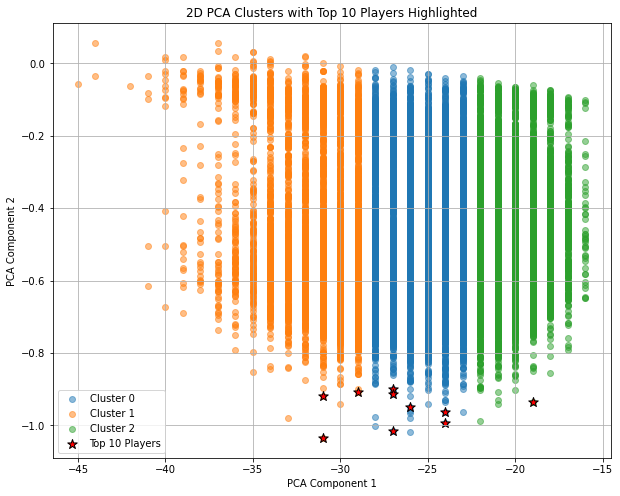

In [25]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Apply PCA and clustering
clusters, top_10_players, best_k, results = apply_pca_and_cluster(df_features, num_components=2)

# Convert Spark DataFrame to Pandas for plotting
clusters_pd = clusters.select("pca_features", "prediction", "Value_norm").toPandas()
top_10_players_pd = top_10_players.select("pca_features", "prediction", "Value_norm").toPandas()

# Extract PCA components for plotting
clusters_pd[["PCA1", "PCA2"]] = clusters_pd["pca_features"].apply(lambda x: pd.Series(x.toArray()))
top_10_players_pd[["PCA1", "PCA2"]] = top_10_players_pd["pca_features"].apply(lambda x: pd.Series(x.toArray()))

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(best_k):
    cluster_points = clusters_pd[clusters_pd["prediction"] == cluster]
    plt.scatter(cluster_points["PCA1"], cluster_points["PCA2"], label=f"Cluster {cluster}", alpha=0.5)

# Highlight top 10 players
plt.scatter(
    top_10_players_pd["PCA1"],
    top_10_players_pd["PCA2"],
    color="red",
    label="Top 10 Players",
    s=100,
    edgecolors="black",
    marker="*",
)

plt.title("2D PCA Clusters with Top 10 Players Highlighted")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid()
plt.show()
